<a href="https://colab.research.google.com/github/victor-roris/NLPlearning/blob/master/text_classification/Transformers_Text_classification_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using Transformer library

Transformers library ([documentation page](https://huggingface.co/transformers/master/quicktour.html) | [github page](https://github.com/huggingface/transformers)):

- Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting-edge NLP easier to use for everyone.

- Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments.

- Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration between them. It's straightforward to train your models with one before loading them for inference with the other.



In [ ]:
!pip install transformers

In this notebook we use a `PyTorch` implementation of a text classification model where we use as input a simple dataset where each entry has a text and label associated. 

This notebook is adaptation of [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/master/transformers_doc/custom_datasets.ipynb#scrollTo=8QALcXp68zcL) and [this notebook](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb)

## Loading the dataset

As example input we use the IMDB dataset ([link](https://huggingface.co/datasets/imdb)). Large Movie Review Dataset. This is a dataset for binary sentiment classification.

We will use the huggingface Datasets library to download the data

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset["train"][0]

{'label': 1,
 'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'}

In [ ]:
train_texts, train_labels = dataset["train"]["text"], dataset["train"]["label"]
test_texts, test_labels = dataset["test"]["text"], dataset["test"]["label"]

In [ ]:
# Limit to train it fast
train_texts = train_texts[:200]
train_labels = train_labels[:200]

## Fine-tuning Transformer Model

#### 1. Identify the task ([list of available tasks](https://huggingface.co/transformers/task_summary.html)):

 - TextClassification

#### 2. Select a pretrained model ([list of available pretrained models](https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads))
- [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased)

In [ ]:
model_checkpoint = "distilbert-base-uncased"   

#### 3. Load tokenizer and model for text classification
- Tokenizer documentation [page](https://huggingface.co/transformers/master/main_classes/tokenizer.html)
- Model documentation [page](https://huggingface.co/transformers/master/main_classes/model.html)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrainin

Basic examples of usage

In [ ]:
# Example of usage of the tokenizer
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Example of usage of the model
pt_batch = tokenizer(
     ["This is an example of usage."],
     padding=True,
     truncation=True,
     return_tensors="pt"
)

logits = model(**pt_batch).logits
logits.tolist()[0]

[0.11427704989910126, -0.019518937915563583]

####4. Preprocessing the dataset

In [ ]:
# Tokenize text
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Now, let's turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a `torch.utils.data.Dataset` object and implementing `__len__` and `__getitem__`. In TensorFlow, we pass our input encodings and labels to the `from_tensor_slices` constructor method. We put the data in this format so that the data can be easily batched such that each key in the batch encoding corresponds to a named parameter of the `DistilBertForSequenceClassification.forward` method of the model we will train.

In [ ]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

####5. Fine-tune

The `Trainer` and `TFTrainer` classes provide an API for feature-complete training in most standard use cases. [Trainer documentation page](https://huggingface.co/transformers/main_classes/trainer.html).

Before instantiating your `Trainer`/`TFTrainer`, create a `TrainingArguments`/`TFTrainingArguments` to access all the points of customization during training.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)


Then we can define the metric for the training. In this case we use datasets library ([documentation page](https://huggingface.co/docs/datasets/loading_metrics.html))

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Train

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # custom metric
)

trainer.train()

***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 39
/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=39, training_loss=0.6486422220865885, metrics={'train_runtime': 50.889, 'train_samples_per_second': 11.79, 'train_steps_per_second': 0.766, 'total_flos': 79480439193600.0, 'train_loss': 0.6486422220865885, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

 Furthermore, `Trainer` supports hyperparameter search using optuna or ray tune ([example code](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb))

On the other hand, Transformers allows to fine-tuning with native PyTorch/TensorFlow

```python
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()
```

## Evaluation

In [ ]:
!pip install scikit-plot

In [ ]:
# Generate some example testing dataset
x_tests = test_texts[:4]+test_texts[-4:]
y_true = test_labels[:4]+test_labels[-4:]

In [ ]:
# Tokenize input
def preprocess_function(examples):
    return tokenizer(examples, truncation=True, padding=True, return_tensors="pt")

evaluation_encodings = preprocess_function(x_tests)

In [ ]:
# Move to CUDA the input (because currently model is already in CUDA)
evaluation_encodings = evaluation_encodings.to("cuda:0")

In [ ]:
# Run prediction
outputs = model(**evaluation_encodings)

In [ ]:
# Get predictions
logits = outputs.logits

In [ ]:
# Converte predictions to labels
y_pred = [bool(logit.argmax()) for logit in logits]
print(y_pred[0:10])

[True, True, True, True, True, True, True, True]


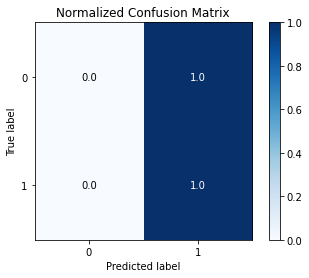

In [ ]:
# Visualize prediction
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True)

## Save

In [ ]:
model.save_pretrained("path/to/repo/clone/your-model-name")
tokenizer.save_pretrained("path/to/repo/clone/your-model-name")